# Google Envir

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import reciprocal
from tqdm import tqdm
import dill
from typing import Union
import scipy

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler , OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline

#Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso


#Features selection
from sklearn.feature_selection import SelectKBest, SelectFromModel, SequentialFeatureSelector

import warnings
warnings.filterwarnings("ignore")

# Read data

In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/P integrador/total_sales_clean.csv')
df=df.drop(df.columns[[0]],axis=1)
df

,date,state_id,cat_id,sell_price,value,total_sells
0,2011-01-29,CA,FOODS,4059.66,8878,3.604166e+07
1,2011-01-29,CA,HOBBIES,1470.28,1644,2.417140e+06
2,2011-01-29,CA,HOUSEHOLD,3594.69,2048,7.361925e+06
3,2011-01-30,CA,FOODS,3750.99,8593,3.223226e+07
4,2011-01-30,CA,HOBBIES,1334.13,1325,1.767722e+06
...,...,...,...,...,...,...
5808,2016-05-21,CA,HOBBIES,4105.49,2156,8.851436e+06
5809,2016-05-21,CA,HOUSEHOLD,8765.58,5201,4.558978e+07
5810,2016-05-22,CA,FOODS,9338.38,13594,1.269459e+08
5811,2016-05-22,CA,HOBBIES,4266.53,2060,8.789052e+06


# Total Sales all Categories

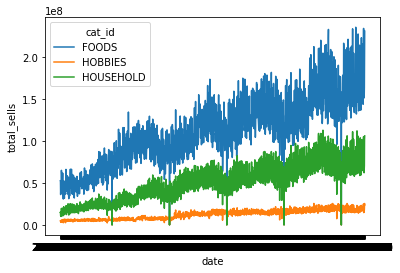

In [ ]:
sns.lineplot(data= df, x = "date", y="total_sells", hue="cat_id" )

# **FOODS** ✅

## DATA

In [3]:
df_hobbies = df.query("cat_id ==  'FOODS'")
df_hobbies = df_hobbies.reset_index()
df_hobbies=df_hobbies.drop(df_hobbies.columns[[0]],axis=1)
df_hobbies

,date,state_id,cat_id,sell_price,value,total_sells
0,2011-01-29,CA,FOODS,4059.66,8878,3.604166e+07
1,2011-01-30,CA,FOODS,3750.99,8593,3.223226e+07
2,2011-01-31,CA,FOODS,3255.72,5998,1.952781e+07
3,2011-02-01,CA,FOODS,3335.46,6862,2.288793e+07
4,2011-02-02,CA,FOODS,3175.49,6071,1.927840e+07
...,...,...,...,...,...,...
1936,2016-05-18,CA,FOODS,7754.64,8802,6.825634e+07
1937,2016-05-19,CA,FOODS,7926.67,9035,7.161746e+07
1938,2016-05-20,CA,FOODS,8093.59,9669,7.825692e+07
1939,2016-05-21,CA,FOODS,9283.17,12600,1.169679e+08


In [4]:
df_hobbies = df_hobbies[df_hobbies['total_sells'] >= 200]
df_hobbies=df_hobbies.reset_index(drop=True)

Initial Split, test 30 days

In [5]:
new_df_hobbies, X_test, y_test= df_hobbies.iloc[:-30, :], df_hobbies.iloc[-30:,df_hobbies.columns!='total_sells'], df_hobbies.iloc[-30:, -1]

## Plots

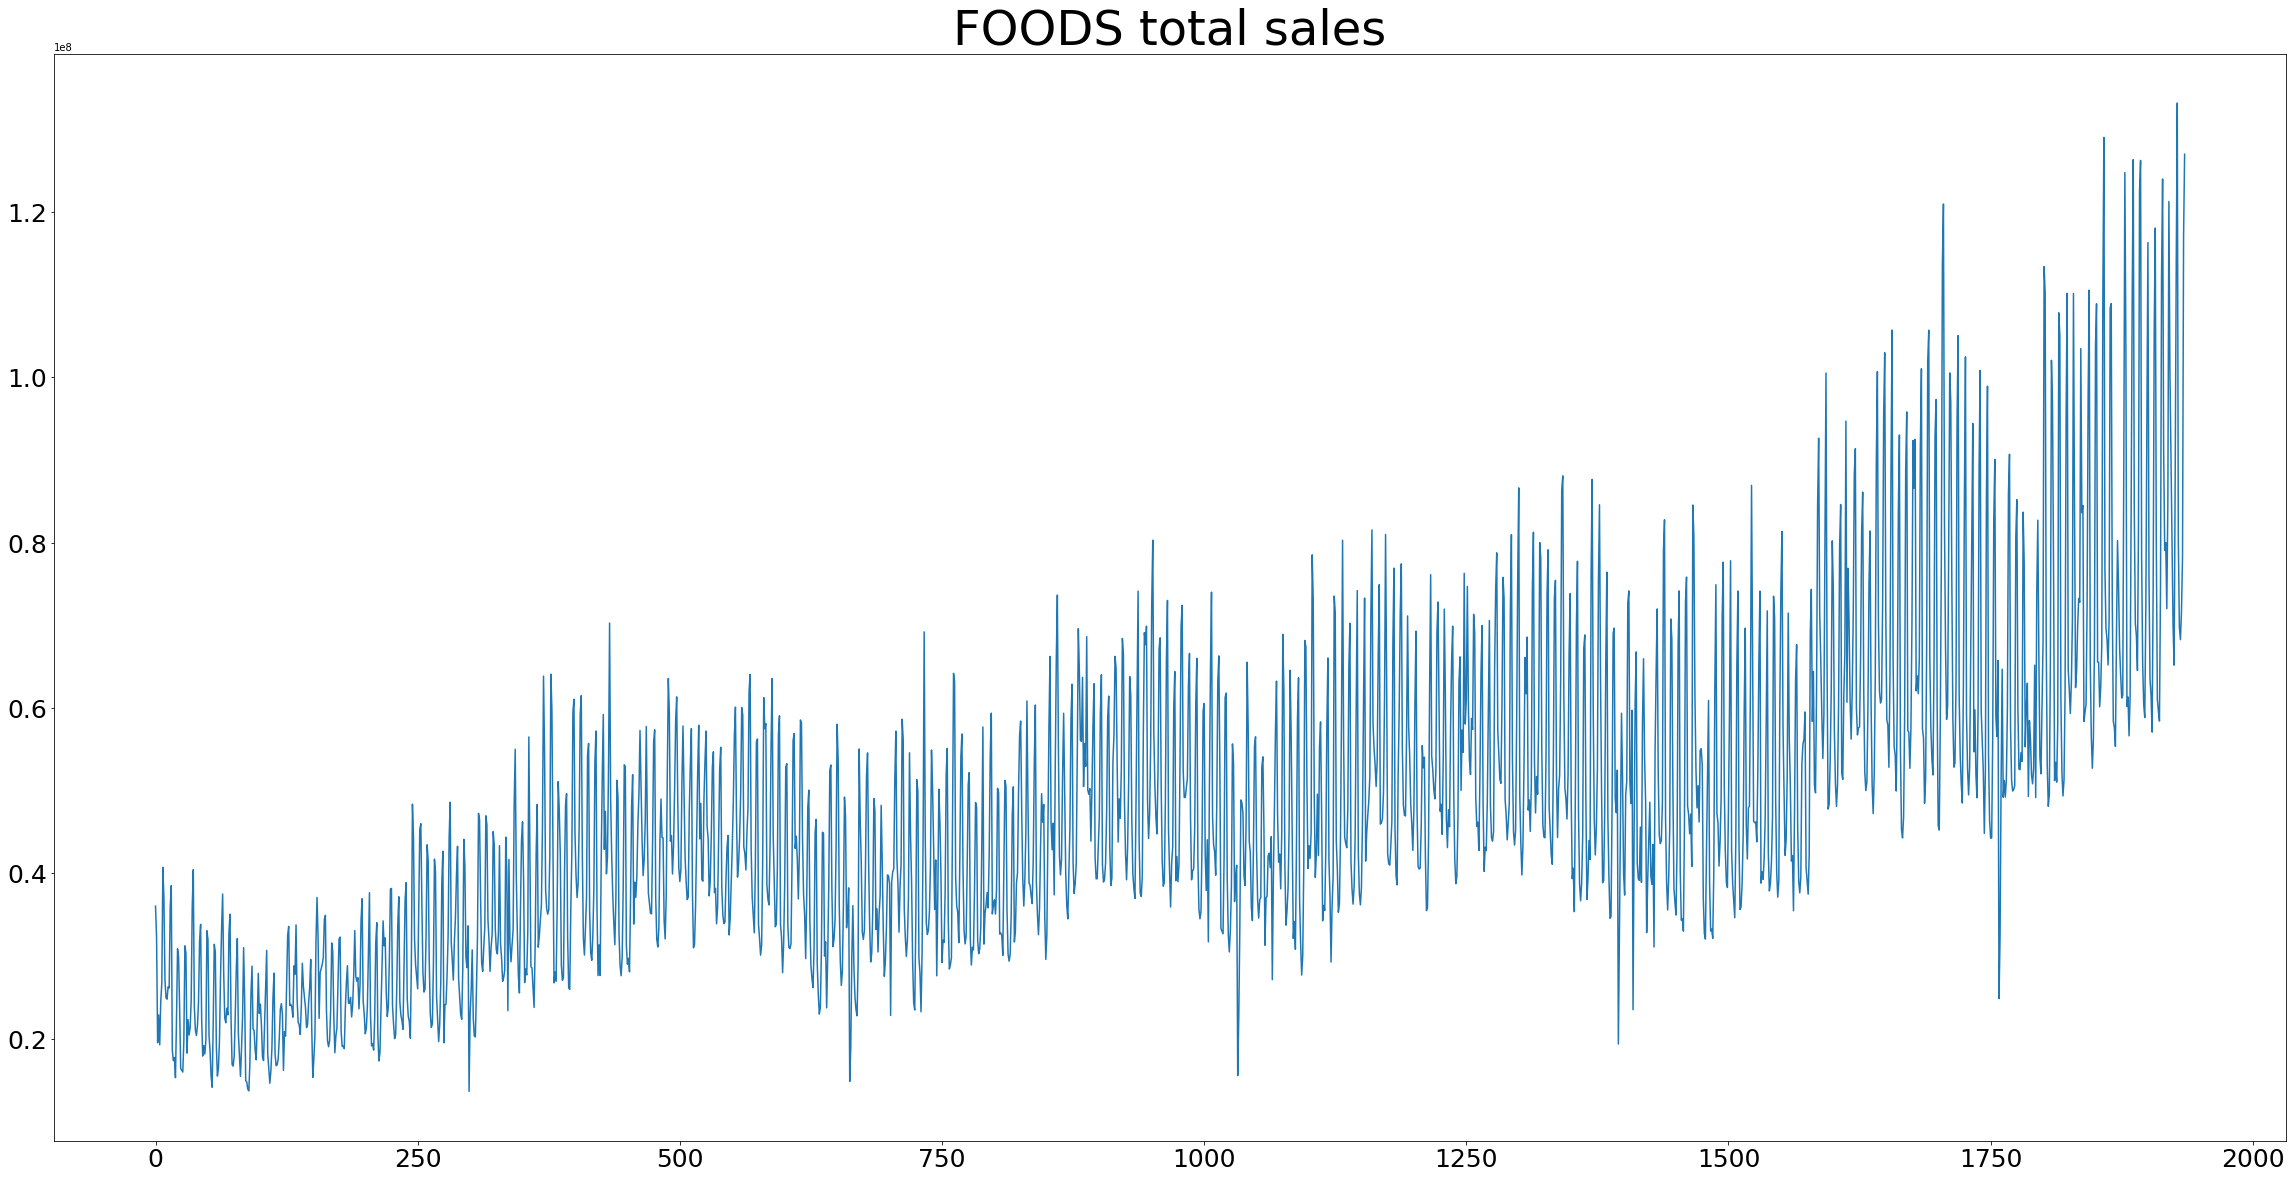

In [ ]:
plt.figure(figsize=(40, 20))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('FOODS total sales',fontsize=48)
plt.plot(df_hobbies.index,df_hobbies['total_sells'])
plt.show()

## **Process DataFrame with Year, Month Ordinal and Lags**

In [6]:
from datetime import datetime

In [7]:
datelist=[]
for i in range(0,len(new_df_hobbies)):

  datelist.append(datetime.strptime((new_df_hobbies.loc[i,'date']), '%Y-%m-%d'))

In [8]:
new_df_hobbies['datenew']=datelist

In [9]:
df_hobbies_time = new_df_hobbies[['state_id', 'cat_id', 'sell_price', 'value', 'datenew', 'total_sells']]

In [10]:
df_hobbies_time.tail()

,state_id,cat_id,sell_price,value,datenew,total_sells
1901,CA,FOODS,8148.98,9338,2016-04-18,76095175.24
1902,CA,FOODS,7590.88,8366,2016-04-19,63505302.08
1903,CA,FOODS,7426.22,8282,2016-04-20,61503954.04
1904,CA,FOODS,7271.09,7850,2016-04-21,57078056.50
1905,CA,FOODS,8042.55,9240,2016-04-22,74313162.00


In [11]:
variables_list=[]
l = 30 #Lags
for i in range(0, len(new_df_hobbies.index) - l):
  variables_list.append( df_hobbies_time.iloc[i:i+l, -1].values)
df_var_Hobbies = pd.DataFrame(variables_list)
df_var_Hobbies.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,36041661.48,32232257.07,19527808.56,22887926.52,19278399.79,24558648.01,26766576.64,40729315.60,37018729.09,27078024.32,...,22419567.24,30882805.70,29846283.30,23618149.65,16400479.94,16177478.03,15981443.78,19734949.68,31244981.49,30364678.50
1,32232257.07,19527808.56,22887926.52,19278399.79,24558648.01,26766576.64,40729315.60,37018729.09,27078024.32,24952493.80,...,30882805.70,29846283.30,23618149.65,16400479.94,16177478.03,15981443.78,19734949.68,31244981.49,30364678.50,18268945.54
2,19527808.56,22887926.52,19278399.79,24558648.01,26766576.64,40729315.60,37018729.09,27078024.32,24952493.80,24795268.98,...,29846283.30,23618149.65,16400479.94,16177478.03,15981443.78,19734949.68,31244981.49,30364678.50,18268945.54,22310679.93
3,22887926.52,19278399.79,24558648.01,26766576.64,40729315.60,37018729.09,27078024.32,24952493.80,24795268.98,26288047.50,...,23618149.65,16400479.94,16177478.03,15981443.78,19734949.68,31244981.49,30364678.50,18268945.54,22310679.93,20464239.14
4,19278399.79,24558648.01,26766576.64,40729315.60,37018729.09,27078024.32,24952493.80,24795268.98,26288047.50,26143431.40,...,16400479.94,16177478.03,15981443.78,19734949.68,31244981.49,30364678.50,18268945.54,22310679.93,20464239.14,21316284.12


In [12]:
Df_hobbies_final=pd.concat([df_var_Hobbies, (df_hobbies_time.loc[l:,['datenew','total_sells']].reset_index()).drop(['index'],axis=1)], ignore_index=True, axis=1,sort=False)

In [13]:
Df_hobbies_final.set_axis(['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'date','total_sales'], axis='columns', inplace=True)

In [14]:
Df_hobbies_final.head()

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,...,l23,l24,l25,l26,l27,l28,l29,l30,date,total_sales
0,36041661.48,32232257.07,19527808.56,22887926.52,19278399.79,24558648.01,26766576.64,40729315.60,37018729.09,27078024.32,...,29846283.30,23618149.65,16400479.94,16177478.03,15981443.78,19734949.68,31244981.49,30364678.50,2011-02-28,18268945.54
1,32232257.07,19527808.56,22887926.52,19278399.79,24558648.01,26766576.64,40729315.60,37018729.09,27078024.32,24952493.80,...,23618149.65,16400479.94,16177478.03,15981443.78,19734949.68,31244981.49,30364678.50,18268945.54,2011-03-01,22310679.93
2,19527808.56,22887926.52,19278399.79,24558648.01,26766576.64,40729315.60,37018729.09,27078024.32,24952493.80,24795268.98,...,16400479.94,16177478.03,15981443.78,19734949.68,31244981.49,30364678.50,18268945.54,22310679.93,2011-03-02,20464239.14
3,22887926.52,19278399.79,24558648.01,26766576.64,40729315.60,37018729.09,27078024.32,24952493.80,24795268.98,26288047.50,...,16177478.03,15981443.78,19734949.68,31244981.49,30364678.50,18268945.54,22310679.93,20464239.14,2011-03-03,21316284.12
4,19278399.79,24558648.01,26766576.64,40729315.60,37018729.09,27078024.32,24952493.80,24795268.98,26288047.50,26143431.40,...,15981443.78,19734949.68,31244981.49,30364678.50,18268945.54,22310679.93,20464239.14,21316284.12,2011-03-04,24638537.30


Max, Min, Mean, median, desv, kurt

In [15]:
#Max
Df_hobbies_final["max1M"] =  Df_hobbies_final.shift(1).rolling(30)["total_sales"].max()
Df_hobbies_final["max2M"] =  Df_hobbies_final.shift(1).rolling(60)["total_sales"].max()
Df_hobbies_final["max6M"] =  Df_hobbies_final.shift(1).rolling(180)["total_sales"].max()

#Min
Df_hobbies_final["min1M"] =  Df_hobbies_final.shift(1).rolling(30)["total_sales"].min()
Df_hobbies_final["min2M"] =  Df_hobbies_final.shift(1).rolling(60)["total_sales"].min()
Df_hobbies_final["min6M"] =  Df_hobbies_final.shift(1).rolling(180)["total_sales"].min()
#mean
Df_hobbies_final["mean1M"] =  Df_hobbies_final.shift(1).rolling(30)["total_sales"].mean()
Df_hobbies_final["mean2M"] =  Df_hobbies_final.shift(1).rolling(60)["total_sales"].mean()
Df_hobbies_final["mean6M"] =  Df_hobbies_final.shift(1).rolling(180)["total_sales"].mean()
# Std
Df_hobbies_final["std1M"] =  Df_hobbies_final.shift(1).rolling(30)["total_sales"].std()
Df_hobbies_final["std2M"] =  Df_hobbies_final.shift(1).rolling(60)["total_sales"].std()
Df_hobbies_final["std6M"] =  Df_hobbies_final.shift(1).rolling(180)["total_sales"].std()
#kurt
Df_hobbies_final["kur1M"] =  Df_hobbies_final.shift(1).rolling(30)["total_sales"].kurt()
Df_hobbies_final["kur2M"] =  Df_hobbies_final.shift(1).rolling(60)["total_sales"].kurt()
Df_hobbies_final["kur6M"] =  Df_hobbies_final.shift(1).rolling(180)["total_sales"].kurt()



In [16]:
Df_hobbies_final=Df_hobbies_final.iloc[180:,:]

In [17]:
Df_hobbies_final.head()

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,...,min6M,mean1M,mean2M,mean6M,std1M,std2M,std6M,kur1M,kur2M,kur6M
180,18810577.20,23719534.67,26748857.25,28839514.76,24321026.04,24290442.00,25004405.13,22646212.38,24104135.04,27728594.20,...,13707622.5,2.554443e+07,2.547971e+07,2.390329e+07,4.991393e+06,5.579053e+06,5.782186e+06,0.558663,-0.689008,-0.340760
181,23719534.67,26748857.25,28839514.76,24321026.04,24290442.00,25004405.13,22646212.38,24104135.04,27728594.20,33083190.18,...,13707622.5,2.597067e+07,2.575064e+07,2.397734e+07,4.942270e+06,5.472097e+06,5.794961e+06,0.280477,-0.797235,-0.380577
182,26748857.25,28839514.76,24321026.04,24290442.00,25004405.13,22646212.38,24104135.04,27728594.20,33083190.18,27540152.49,...,13707622.5,2.631459e+07,2.602411e+07,2.404249e+07,5.135434e+06,5.469327e+06,5.841845e+06,-0.217257,-0.893764,-0.438727
183,28839514.76,24321026.04,24290442.00,25004405.13,22646212.38,24104135.04,27728594.20,33083190.18,27540152.49,26957665.35,...,13707622.5,2.610865e+07,2.602801e+07,2.404308e+07,5.240232e+06,5.465287e+06,5.841486e+06,-0.281321,-0.891785,-0.438390
184,24321026.04,24290442.00,25004405.13,22646212.38,24104135.04,27728594.20,33083190.18,27540152.49,26957665.35,27388667.20,...,13707622.5,2.572499e+07,2.578737e+07,2.402093e+07,5.450519e+06,5.525788e+06,5.859412e+06,-0.254064,-0.821909,-0.452693


In [18]:
yearlist=[]
for i in (Df_hobbies_final).index: #range(0,len(Df_hobbies_final)):
  yearlist.append((Df_hobbies_final.loc[i,'date']).year)
Df_hobbies_final['year']=yearlist

In [19]:
monthlist=[]
for i in (Df_hobbies_final).index:
  monthlist.append((Df_hobbies_final.loc[i,'date']).month)
Df_hobbies_final['month']=monthlist

In [20]:
#Df_hobbies_final=Df_hobbies_final[['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10','month','year','total_sales']]
Df_hobbies_final=Df_hobbies_final[['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'max1M', 'max2M','max6M','min1M', 'min2M','min6M', 'mean1M','mean2M', 'mean6M', 'std1M', 'std2M',
'std6M', 'kur1M', 'kur2M','kur6M', 'month', 'year',  'total_sales']]
Df_hobbies_final.head()

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,...,mean6M,std1M,std2M,std6M,kur1M,kur2M,kur6M,month,year,total_sales
180,18810577.20,23719534.67,26748857.25,28839514.76,24321026.04,24290442.00,25004405.13,22646212.38,24104135.04,27728594.20,...,2.390329e+07,4.991393e+06,5.579053e+06,5.782186e+06,0.558663,-0.689008,-0.340760,8,2011,31597868.76
181,23719534.67,26748857.25,28839514.76,24321026.04,24290442.00,25004405.13,22646212.38,24104135.04,27728594.20,33083190.18,...,2.397734e+07,4.942270e+06,5.472097e+06,5.794961e+06,0.280477,-0.797235,-0.380577,8,2011,34037189.48
182,26748857.25,28839514.76,24321026.04,24290442.00,25004405.13,22646212.38,24104135.04,27728594.20,33083190.18,27540152.49,...,2.404249e+07,5.135434e+06,5.469327e+06,5.841845e+06,-0.217257,-0.893764,-0.438727,8,2011,20570542.20
183,28839514.76,24321026.04,24290442.00,25004405.13,22646212.38,24104135.04,27728594.20,33083190.18,27540152.49,26957665.35,...,2.404308e+07,5.240232e+06,5.465287e+06,5.841486e+06,-0.281321,-0.891785,-0.438390,8,2011,17329739.96
184,24321026.04,24290442.00,25004405.13,22646212.38,24104135.04,27728594.20,33083190.18,27540152.49,26957665.35,27388667.20,...,2.402093e+07,5.450519e+06,5.525788e+06,5.859412e+06,-0.254064,-0.821909,-0.452693,8,2011,18322857.08


**Standard scaler independet variables**

In [21]:
standar = StandardScaler()
Xstandarized = standar.fit_transform(Df_hobbies_final.loc[:,Df_hobbies_final.columns!='total_sales'])

In [22]:
dataStandarized=pd.DataFrame(Xstandarized,columns=['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'max1M', 'max2M','max6M','min1M', 'min2M','min6M', 'mean1M','mean2M', 'mean6M', 'std1M', 'std2M',
'std6M', 'kur1M', 'kur2M','kur6M', 'month', 'year'])
y = Df_hobbies_final['total_sales']

Split

In [23]:
X_train, X_valid, y_train, y_valid = dataStandarized.iloc[:-15,:], dataStandarized.iloc[-15:,:], y.iloc[:-15], y.iloc[-15:]

**Correlation Matrix**

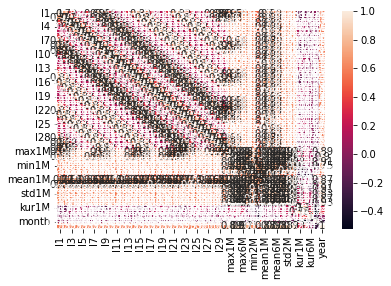

In [24]:
sns.heatmap(Df_hobbies_final.loc[:,Df_hobbies_final.columns!='total_sales'].corr(), annot=True)
plt.show()

## Feature Engineering

### function

In [ ]:
def evaluation_models(X_train, X_valid, y_train, y_valid):
  param_grid = {'max_leaf_nodes': [10, 12,15,20], 
              'n_estimators': [100,150,200]}

  #rfgs = GridSearchCV(RandomForestRegressor(), cv=3, param_grid=param_grid)
  gbgs = GridSearchCV(GradientBoostingRegressor(), cv=3, param_grid=param_grid)
  #rfgs.fit(X_train,y_train)
  gbgs.fit(y_train,y_train)

  #rf=RandomForestRegressor(n_estimators=rfgs.best_params_['n_estimators'],max_leaf_nodes=rfgs.best_params_['max_leaf_nodes'])
  #rf.fit(X_train,y_train)
  gb=GradientBoostingRegressor(n_estimators=gbgs.best_params_['n_estimators'],max_leaf_nodes=gbgs.best_params_['max_leaf_nodes'])
  gb.fit(X_train,y_train)
  # print('MAE VALID RF')
  # print(mean_absolute_error(y_valid, rf.predict(X_valid)))
  print('MAE VALID GB')
  print(mean_absolute_error(y_valid, gb.predict(X_valid)))


In [ ]:
import warnings
warnings.filterwarnings("ignore")

### All features

In [ ]:
evaluation_models(X_train, X_valid, (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
7885642.2345387405


### Corr Pearson

In [ ]:
mat_spearman = Df_hobbies_final.corr('pearson')
#Correlation with output variable
cor_target = abs(mat_spearman['total_sales'])
#Selecting highly correlated features
relevant_features = (cor_target[cor_target>0.60].to_frame().T).drop('total_sales', axis=1)
(relevant_features)

,l2,l3,l4,l9,l10,l11,l16,l17,l18,l23,...,l30,max1M,max2M,max6M,min1M,mean1M,mean2M,mean6M,std6M,year
total_sales,0.657363,0.859685,0.675809,0.626869,0.820928,0.632968,0.623028,0.828928,0.633938,0.663279,...,0.726593,0.643618,0.632229,0.632283,0.613201,0.667901,0.641497,0.607199,0.620842,0.600229


Evaluation

In [ ]:
evaluation_models(X_train.loc[:,list(relevant_features)], 
                  X_valid.loc[:,list(relevant_features)],
                  (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
8614785.250884386


### Corr Spearman

In [ ]:
mat_spearman = Df_hobbies_final.corr('spearman')
#Correlation with output variable
cor_target = abs(mat_spearman['total_sales'])
#Selecting highly correlated features
relevant_features = (cor_target[cor_target>0.60].to_frame().T).drop('total_sales', axis=1)
(relevant_features)

,l2,l3,l4,l9,l10,l11,l16,l17,l18,l23,...,l25,l30,max1M,max2M,max6M,min1M,mean1M,mean2M,std6M,year
total_sales,0.689397,0.860828,0.699673,0.639063,0.80339,0.640941,0.622116,0.800032,0.6374,0.672384,...,0.6844,0.751886,0.628391,0.61614,0.629847,0.606849,0.669211,0.637782,0.60286,0.600719


**Evaluation**

In [ ]:
evaluation_models(X_train.loc[:,list(relevant_features)], 
                  X_valid.loc[:,list(relevant_features)], 
                  (y_train).values.reshape(-1,1), 
                  (y_valid).values.reshape(-1,1))

MAE VALID GB
8119546.763512472


### RF Feature import

In [ ]:
rf = RandomForestRegressor(random_state=123)

rf.fit(dataStandarized,y)

RandomForestRegressor(random_state=123)

<Figure size 640x480 with 0 Axes>

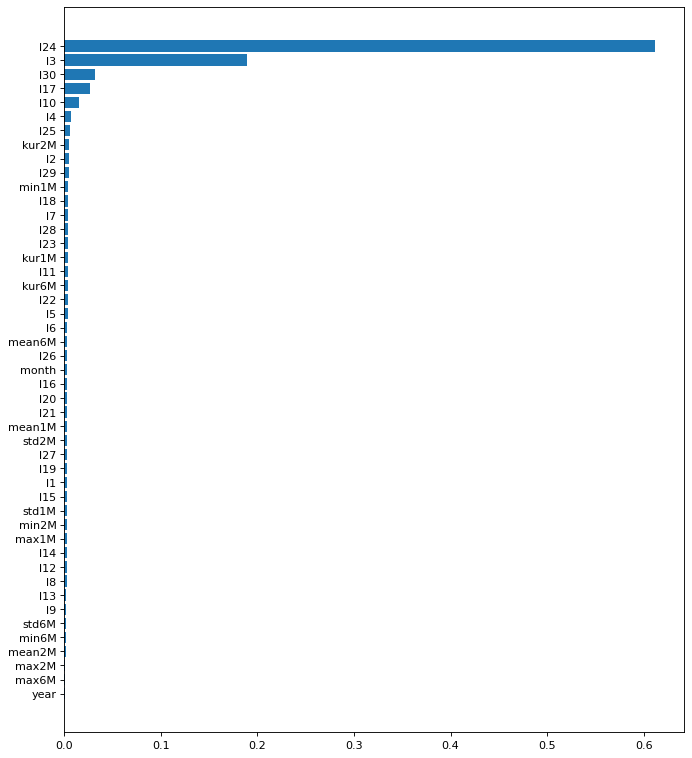

In [ ]:
f_i = list(zip(X_train.columns,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])

figure(figsize=(8, 6), dpi=80)
figure(figsize=(10, 12), dpi=80)
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

**Evaluation**

In [ ]:
evaluation_models(X_train.loc[:,['l24','l3','l30','l17','l10']], X_valid.loc[:,['l24','l3','l30','l17','l10']], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
9498694.434685886


### Recursive Elimination

In [ ]:
estimator = RandomForestRegressor(max_leaf_nodes= 12, max_features=2, n_estimators=100, random_state=123)
selector = RFE(estimator, n_features_to_select=10 ,step=1)
selector = selector.fit(dataStandarized, y.values)
print(selector.support_)
print(selector.ranking_)
ind =np.nonzero(selector.support_)[0]

[False  True  True  True False False False False False  True False False
 False False False False  True False False False False False  True  True
  True False False False False  True False False False False False False
  True False False False False False False False False False False]
[21  1  1  1 35 26 32 31  7  1  3 20 19 28 29  4  1 10 33 17 13 30  1  1
  1 18 24 15 14  1 11  6  2  5 16 23  1  8 12 25 27  9 37 36 34 38 22]


Evaluation

In [ ]:
evaluation_models(X_train.iloc[:,ind.tolist()], X_valid.iloc[:,ind.tolist()], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
8264904.602964437


### Backward "Sequential feature selection"

In [ ]:
#Primera iteración
sfs = SequentialFeatureSelector(Lasso(alpha=0.001))
sfs.fit(dataStandarized, y)
ind =np.nonzero(sfs.get_support())[0]
print(sfs.get_support())
Xstandarized[:,ind].shape

[ True False  True  True False False  True  True  True  True False False
 False False False  True  True False  True False  True  True  True  True
  True False False False False  True False  True False  True False False
 False  True False False False  True  True  True False  True False]


(1696, 23)

In [ ]:
evaluation_models(X_train.iloc[:,ind.tolist()], X_valid.iloc[:,ind.tolist()], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
7940500.571063041


In [ ]:
X_train.iloc[:,ind.tolist()].columns

Index(['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21',
       'l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month'],
      dtype='object')

###

## **Models**,  'X and Y Scaled' , **Best selection features: Backward Select: 'l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21',        'l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',        'kur1M', 'kur2M', 'month'**

### Scaled and Split

In [25]:
scaler  = MinMaxScaler()
Xscaled = scaler.fit_transform(Df_hobbies_final.loc[:,Df_hobbies_final.columns!='total_sales'])

In [26]:
yscaled=scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1))

In [27]:
dataScaled=pd.DataFrame(Xscaled, columns=['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'max1M', 'max2M','max6M','min1M', 'min2M','min6M', 'mean1M','mean2M', 'mean6M', 'std1M', 'std2M',
'std6M', 'kur1M', 'kur2M','kur6M', 'month', 'year'])

Split

In [28]:
X_trainScaled, X_validScaled, y_trainScaled, y_validScaled = dataScaled.iloc[:-15,:], dataScaled.iloc[-15:,:], yscaled[:-15], yscaled[-15:]

### kNN

In [ ]:
knn = KNeighborsRegressor()
# parameters i.e. k neighbors list
parameters = {'n_neighbors':range(1,50)}
    
# Training the model
model = GridSearchCV(knn, param_grid = parameters, cv=5)
model.fit(X_trainScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21',
       'l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']], y_trainScaled)
print('Best value of k is ',model.best_params_)

Best value of k is  {'n_neighbors': 9}


In [ ]:
knn = KNeighborsRegressor(n_neighbors=model.best_params_['n_neighbors'])
knn.fit(X_trainScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21',
       'l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']], y_trainScaled)

KNeighborsRegressor(n_neighbors=9)

In [ ]:
print('MAE Train:', mean_absolute_error( scaler.inverse_transform(y_trainScaled), scaler.inverse_transform(knn.predict(X_trainScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21',
       'l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']]) )),'\n')
print('MAE Valid:', mean_absolute_error( scaler.inverse_transform(y_validScaled), scaler.inverse_transform(knn.predict(X_validScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21',
       'l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']]) )),'\n')

MAE Train: 4375003.96922599 

MAE Valid: 6811482.043629631 



### RF

In [ ]:
random_grid = {'n_estimators': [30,50,100,150],
               'max_features': [10,12,15,20],  'max_leaf_nodes': [15,20,22,25]}
rf = RandomForestRegressor()
rf_GS = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 4)
# Fit the random search model
rf_GS.fit(X_trainScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']], y_trainScaled[:,0])
print('Best parameters ',rf_GS.best_params_)

Best parameters  {'max_features': 15, 'max_leaf_nodes': 25, 'n_estimators': 30}


In [ ]:
rf = RandomForestRegressor( n_estimators = rf_GS.best_params_['n_estimators'], max_features= rf_GS.best_params_['max_features'], max_leaf_nodes= rf_GS.best_params_['max_leaf_nodes'])
rf.fit(X_trainScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21',
       'l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']], y_trainScaled[:,0])

RandomForestRegressor(max_features=15, max_leaf_nodes=25, n_estimators=30)

In [ ]:
print('MAE Train:', mean_absolute_error( scaler.inverse_transform(y_trainScaled).reshape(-1,1), scaler.inverse_transform(rf.predict(X_trainScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21',
       'l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']]).reshape(-1,1) )),'\n')
print('MAE Valid:', mean_absolute_error( scaler.inverse_transform(y_validScaled).reshape(-1,1), scaler.inverse_transform(rf.predict(X_validScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21',
       'l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']]).reshape(-1,1) )))

MAE Train: 4432347.23791405 

MAE Valid: 8558854.795389116


### Gradient Boosting

In [ ]:
param_grid = {'n_estimators': [35,50,100,150],
               'max_features': [10,13,15,19],  'max_leaf_nodes': [15,20,23,26]}
gbgs = GridSearchCV(GradientBoostingRegressor(), cv=4, param_grid=param_grid)
gbgs.fit(X_trainScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']], y_trainScaled[:,0])

GridSearchCV(cv=4, estimator=GradientBoostingRegressor(),
             param_grid={'max_features': [10, 13, 15, 19],
                         'max_leaf_nodes': [15, 20, 23, 26],
                         'n_estimators': [35, 50, 100, 150]})

In [ ]:
gb=GradientBoostingRegressor(n_estimators = gbgs.best_params_['n_estimators'], max_features= gbgs.best_params_['max_features'], max_leaf_nodes=gbgs.best_params_['max_leaf_nodes'])
gb.fit(X_trainScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']], y_trainScaled[:,0])

GradientBoostingRegressor(max_features=15, max_leaf_nodes=20, n_estimators=150)

In [ ]:
print('MAE Train:', mean_absolute_error(y_train, gb.predict(X_train.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']]) ),'\n')
print('MAE valid:', mean_absolute_error(y_valid, gb.predict(X_valid.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']]) ))

MAE Train: 49638152.562076956 

MAE valid: 80497906.33148836


### SVR

In [ ]:
param_grid = {'kernel': ['poly'], 'C': [100,500,1000,5000], 'degree': range(2,6)} 
  
grid = GridSearchCV( SVR(), param_grid, cv = 4)
grid.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled[:,0])
grid.best_params_

In [ ]:
regressor = SVR(kernel ='poly', C=grid.best_params_['C'], degree=grid.best_params_['degree'] )
# fit the model on the data
regressor.fit(X_trainScaled.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], y_trainScaled[:,0])

In [ ]:
print('MAE Train:', mean_absolute_error(y_train, regressor.predict(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')
print('MAE valid:', mean_absolute_error(y_valid, regressor.predict(X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']]) ),'\n')


MAE Train: 763292.3291559427 

MAE valid: 634416.2358027374 



### RF-kNN - JJ

#### Functions

In [49]:
class RF_KNN:
    def __init__(
        self,
        n_trees: int = 100,
        max_leaf_nodes: int = 7,
        min_samples_leaf: int = 10,
        max_features: int = 2,
        n_neighbors: int = 7,
        p: int =2 ):
      
        self.n_trees = n_trees
        self.max_leaf_nodes = max_leaf_nodes
        self.min_samples_leaf= min_samples_leaf
        self.max_features= max_features
        self.n_neighbors = n_neighbors
        self.p = p
        self.rf = RandomForestRegressor(
            n_estimators=self.n_trees,
            max_leaf_nodes=self.max_leaf_nodes,
            min_samples_leaf=self.min_samples_leaf, max_features = self.max_features
        )
        self.scaler = MinMaxScaler()

    def get_idxs_dict(self, leaves: np.ndarray):
        idxs_dict = {}

        for tree in range(self.n_trees):
            col = leaves[:, tree]

            for leaf in np.unique(col):
                # Get the indices of the data samples in each tree-leaf pair:
                idxs_dict[(tree, leaf)] = np.flatnonzero(col == leaf)
        
        return idxs_dict

    def fit(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.DataFrame],
    ):
        # Turn data to numpy arrays if they come as DataFrames or series:

        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values

        # Normalize the data:
       # X = self.scaler.fit_transform(X)

        self.rf.fit(X, y)
        leaves = self.rf.apply(X)
        idxs_dict = self.get_idxs_dict(leaves)

        self.knn_dict = {}
        knn_predictions = [[] for _ in range(len(X))]
        
        print("Training the kNN classifiers:")
        for (tree, leaf), idxs in tqdm(idxs_dict.items()):
            knn = KNeighborsRegressor(self.n_neighbors, p=self.p)
            knn.fit(X[idxs], y[idxs])
            self.knn_dict[(tree, leaf)] = knn

            for i, pred in zip(idxs, knn.predict(X[idxs])):
                knn_predictions[i].append(pred)
        
        # Get predictions:
        y_pred = scipy.mean(knn_predictions, axis=1)

        # Show performance on training set:
       # print(classification_report(y, y_pred,digits=4))

    def predict(self, X: Union[np.ndarray, pd.DataFrame]):
        # Turn data to numpy arrays if they come as DataFrames or series:
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values

        # Normalize the data:
        #X = self.scaler.transform(X)

        leaves = self.rf.apply(X)
        idxs_dict = self.get_idxs_dict(leaves)

        knn_predictions = [[] for _ in range(len(X))]
        
        print("Predicting with the kNN classifiers:")
        for (tree, leaf), idxs in tqdm(idxs_dict.items()):
            knn = self.knn_dict[(tree, leaf)]

            for i, pred in zip(idxs, knn.predict(X[idxs])):
                knn_predictions[i].append(pred)
        
        # Return predictions:
        return scipy.mean(knn_predictions, axis=1)

#### Prediction

In [30]:
rf_knn = RF_KNN( n_trees = 100,  max_leaf_nodes = 2,  max_features=16,  n_neighbors = 11)

In [31]:
%%time
rf_knn.fit(X_trainScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']], y_trainScaled)

Training the kNN classifiers:


100%|██████████| 200/200 [00:05<00:00, 38.66it/s]


CPU times: user 6.13 s, sys: 4.08 s, total: 10.2 s
Wall time: 5.83 s


In [32]:
print('MAE Train:', mean_absolute_error( scaler.inverse_transform(y_trainScaled), scaler.inverse_transform(rf_knn.predict(X_trainScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']]) )),'\n')
print('MAE Valid:', mean_absolute_error( scaler.inverse_transform(y_validScaled), scaler.inverse_transform(rf_knn.predict(X_validScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M', 'month']]) )))


Predicting with the kNN classifiers:


100%|██████████| 200/200 [00:04<00:00, 40.30it/s]


MAE Train: 4482657.327756292 

Predicting with the kNN classifiers:


100%|██████████| 110/110 [00:00<00:00, 966.98it/s] 

MAE Valid: 7086389.8905012105


## **Process DataFrame with Year, Month Nomimal and Lags** (it wasn't improved)

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [ ]:
encoder_df = pd.DataFrame(encoder.fit_transform(Df_hobbies_final[['month']]).toarray())

In [ ]:
Df_hobbies_final['ene']=encoder_df.iloc[:,0].values
Df_hobbies_final['feb']=encoder_df.iloc[:,1].values
Df_hobbies_final['mar']=encoder_df.iloc[:,2].values
Df_hobbies_final['abr']=encoder_df.iloc[:,3].values
Df_hobbies_final['may']=encoder_df.iloc[:,4].values
Df_hobbies_final['jun']=encoder_df.iloc[:,5].values
Df_hobbies_final['jul']=encoder_df.iloc[:,6].values
Df_hobbies_final['ago']=encoder_df.iloc[:,7].values
Df_hobbies_final['sep']=encoder_df.iloc[:,8].values
Df_hobbies_final['oct']=encoder_df.iloc[:,9].values
Df_hobbies_final['nov']=encoder_df.iloc[:,10].values
Df_hobbies_final['dic']=encoder_df.iloc[:,11].values


In [ ]:
Df_hobbies_final=Df_hobbies_final[['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'max1M', 'max2M','max6M','min1M', 'min2M','min6M', 'mean1M','mean2M', 'mean6M', 'std1M', 'std2M',
'std6M', 'kur1M', 'kur2M','kur6M', 'ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic', 'year',  'total_sales']]

**Standard scaler independet variables**

In [ ]:
standar = StandardScaler()
Xstandarized = standar.fit_transform(Df_hobbies_final.loc[:,Df_hobbies_final.columns!='total_sales'])

In [ ]:
dataStandarized=pd.DataFrame(Xstandarized,columns=['l1','l2','l3','l4','l5','l6','l7','l8','l9','l10'
,'l11','l12','l13','l14','l15','l16','l17','l18','l19','l20',
'l21','l22','l23','l24','l25','l26','l27','l28','l29','l30',
'max1M', 'max2M','max6M','min1M', 'min2M','min6M', 'mean1M','mean2M', 'mean6M', 'std1M', 'std2M',
'std6M', 'kur1M', 'kur2M','kur6M', 'ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic', 'year'])

In [ ]:
y = Df_hobbies_final['total_sales']

Split

In [ ]:
X_train, X_valid, y_train, y_valid = dataStandarized.iloc[:-15,:], dataStandarized.iloc[-15:,:], y.iloc[:-15], y.iloc[-15:]

**Correlation Matrix**

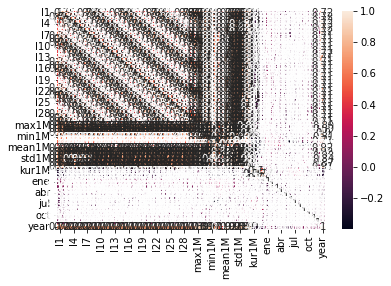

In [ ]:
sns.heatmap(Df_hobbies_final.loc[:,Df_hobbies_final.columns!='total_sales'].corr(), annot=True)
plt.show()

## Feature Engineering

### function

In [ ]:
def evaluation_models(X_train, X_valid, y_train, y_valid):
  param_grid = {'max_leaf_nodes': [10, 12,15,20], 
              'n_estimators': [100,150,200]}

  #rfgs = GridSearchCV(RandomForestRegressor(), cv=3, param_grid=param_grid)
  gbgs = GridSearchCV(GradientBoostingRegressor(), cv=3, param_grid=param_grid)
  #rfgs.fit(X_train,y_train)
  gbgs.fit(y_train,y_train)

  #rf=RandomForestRegressor(n_estimators=rfgs.best_params_['n_estimators'],max_leaf_nodes=rfgs.best_params_['max_leaf_nodes'])
  #rf.fit(X_train,y_train)
  gb=GradientBoostingRegressor(n_estimators=gbgs.best_params_['n_estimators'],max_leaf_nodes=gbgs.best_params_['max_leaf_nodes'])
  gb.fit(X_train,y_train)
  # print('MAE VALID RF')
  # print(mean_absolute_error(y_valid, rf.predict(X_valid)))
  print('MAE VALID GB')
  print(mean_absolute_error(y_valid, gb.predict(X_valid)))


In [ ]:
import warnings
warnings.filterwarnings("ignore")

### All features

In [ ]:
evaluation_models(X_train, X_valid, (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
570810.1163651086


### Corr Pearson

In [ ]:
mat_spearman = Df_hobbies_final.corr('pearson')
#Correlation with output variable
cor_target = abs(mat_spearman['total_sales'])
#Selecting highly correlated features
relevant_features = (cor_target[cor_target>0.75].to_frame().T).drop('total_sales', axis=1)
(relevant_features)

,l3,l10,l17,l24,mean1M,mean2M
total_sales,0.843107,0.838794,0.852872,0.860793,0.764612,0.755059


Evaluation

In [ ]:
evaluation_models(X_train.loc[:,['l3','l10','l17','l24','mean1M','mean2M']], 
                  X_valid.loc[:,['l3','l10','l17','l24','mean1M', 'mean2M']],
                  (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
565245.0616438997


### Corr Spearman

In [ ]:
mat_spearman = Df_hobbies_final.corr('spearman')
#Correlation with output variable
cor_target = abs(mat_spearman['total_sales'])
#Selecting highly correlated features
relevant_features = (cor_target[cor_target>0.75].to_frame().T).drop('total_sales', axis=1)
(relevant_features)

,l2,l3,l4,l9,l10,l11,l16,l17,l18,l23,l24,l25,l30,max1M,max6M,mean1M,mean2M,mean6M,year
total_sales,0.759496,0.852006,0.759751,0.761586,0.849255,0.762627,0.767229,0.866149,0.772324,0.76649,0.866491,0.769692,0.802626,0.752715,0.751752,0.785554,0.769119,0.757081,0.755055


**Evaluation**

In [ ]:
evaluation_models(X_train.loc[:,['l2','l3','l4','l9', 'l10', 'l11','l16','l17','l18','l23','l24','l25','l30','max1M','max6M','mean1M','mean2M','mean6M','year']], 
                  X_valid.loc[:,['l2','l3','l4','l9', 'l10', 'l11','l16','l17','l18','l23','l24','l25','l30','max1M','max6M','mean1M','mean2M','mean6M','year']], 
                  (y_train).values.reshape(-1,1), 
                  (y_valid).values.reshape(-1,1))

MAE VALID GB
605421.369661514


### RF Feature import

In [ ]:
rf = RandomForestRegressor(random_state=123)
rf.fit(dataStandarized,y)

RandomForestRegressor(random_state=123)

<Figure size 640x480 with 0 Axes>

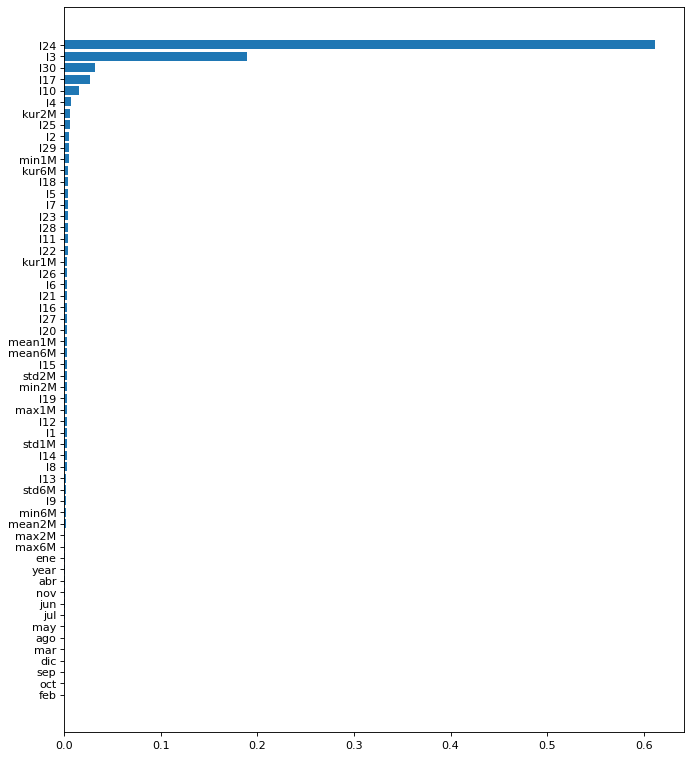

In [ ]:
f_i = list(zip(X_train.columns,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])

figure(figsize=(8, 6), dpi=80)
figure(figsize=(10, 12), dpi=80)
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

**Evaluation**

In [ ]:
evaluation_models(X_train.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], X_valid.loc[:,['l17','l24','l3','l10','l30','std1M','mean1M','std2M','mean6M']], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
548057.2820278466


### Recursive Elimination

features = 5

In [ ]:
estimator = RandomForestRegressor(max_leaf_nodes= 12, max_features=2, n_estimators=100, random_state=123)
selector = RFE(estimator, n_features_to_select=20 ,step=1)
selector = selector.fit(dataStandarized, y.values)
print(selector.support_)
print(selector.ranking_)

[False  True  True  True False False False False  True  True  True False
 False False False  True  True  True False False False False  True  True
  True False False False False  True  True  True  True  True False False
  True  True False False False  True False False False False False False
 False False False False False False False False False False]
[11  1  1  1 25 16 22 21  1  1  1 10  9 18 19  1  1  1 23  7  3 20  1  1
  1  8 14  5  4  1  1  1  1  1  6 13  1  1  2 15 17  1 27 26 24 29 39 31
 33 32 36 30 35 37 38 28 34 12]


In [ ]:
ind =np.nonzero(selector.support_)[0]

In [ ]:
evaluation_models(X_train.iloc[:,ind.tolist()], X_valid.iloc[:,ind.tolist()], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID GB
8454068.13047362


In [ ]:
X_train.iloc[1,ind.tolist()]

l3       -0.896077
l10      -0.793656
l17      -0.495425
l24      -0.723013
l30      -0.391843
mean1M   -1.247201
mean6M   -1.196898
Name: 1, dtype: float64

Evaluation

features = 3

In [ ]:
estimator = RandomForestRegressor(max_leaf_nodes= 12, max_features=2, n_estimators=100, random_state=123)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(dataStandarized, y.values)
print(selector.support_)
print(selector.ranking_)

[False False False  True  True False False False False  True False False]
[ 9  6  2  1  1  4  7  8  5  1 10  3]


In [ ]:
evaluation_models(X_train.iloc[:,[3,4,9]], X_valid.iloc[:,[3,4,9]], (y_train).values.reshape(-1,1), (y_valid).values.reshape(-1,1))

MAE VALID RF
499324.79712458135
MAE VALID GB
494394.4652334016


### Backward "Sequential feature selection"

In [ ]:
#Primera iteración
sfs = SequentialFeatureSelector(LinearRegression())
sfs.fit(dataStandarized, y)
ind =np.nonzero(sfs.get_support())[0]
print(sfs.get_support())
Xstandarized[:,ind].shape

[ True False  True  True False False  True  True  True  True False False
 False  True  True  True  True False  True  True  True  True  True  True
  True False False False False  True False  True False  True False False
 False  True False False False  True False  True  True False False False
 False False  True False  True  True False False  True False]


(1696, 29)

In [ ]:
evaluation_models(X_train.iloc[:,ind.tolist()],X_valid.iloc[:,ind.tolist()],y_train.values.reshape(-1, 1),y_valid.values.reshape(-1, 1))

MAE VALID GB
6938493.605200038


In [ ]:
len(X_train.iloc[1,ind.tolist()])

29

Evaluation

## **Test Performance**

### kNN

In [ ]:
knn = KNeighborsRegressor(n_neighbors=9)
knn.fit(dataScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M','month']], yscaled)

KNeighborsRegressor(n_neighbors=9)

In [ ]:
X_df_test=Df_hobbies_final.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M','month']].reset_index(drop=True)
y_df_test=Df_hobbies_final['total_sales'].reset_index(drop=True)

For Loop

In [ ]:
for i in range(0,9):
  last180=y_df_test.iloc[-180:]
  newX=[]
  newX.append(last180.iloc[-30:].iloc[0]) #l 1
  newX.append(last180.iloc[-30:].iloc[2])  #l 24
  newX.append(last180.iloc[-30:].iloc[3])  #l 13
  newX.append(last180.iloc[-30:].iloc[6])   #l 7
  newX.append(last180.iloc[-30:].iloc[7])  #l 8
  newX.append(last180.iloc[-30:].iloc[8])  #l 9
  newX.append(last180.iloc[-30:].iloc[9])  #l 10
  newX.append(last180.iloc[-30:].iloc[15])  #l 16
  newX.append(last180.iloc[-30:].iloc[16])  #l 17
  newX.append(last180.iloc[-30:].iloc[18])  #l 19
  newX.append(last180.iloc[-30:].iloc[20])  #l 21
  newX.append(last180.iloc[-30:].iloc[21])  #l 22
  newX.append(last180.iloc[-30:].iloc[22])  #l 23
  newX.append(last180.iloc[-30:].iloc[23])  #l 24
  newX.append(last180.iloc[-30:].iloc[24])  #l 25
  newX.append(last180.iloc[-30:].iloc[29])  #l 30

  newX.append(last180.iloc[30:].max())   #Max 2M
  newX.append(last180.iloc[30:].min())   #Min 1M
  newX.append(last180.iloc[60:].mean())   #Mean 2M
  newX.append(last180.values.std())   #std 6M
  newX.append(last180.iloc[30:].kurt())   #Kurt 1M
  newX.append(last180.iloc[60:].kurt())   #Kurt 2M
  newX.append(5)   #month

  X_df_test.loc[len(X_df_test)] = newX
  #Final Prediction with test
  scaled= scaler.fit_transform(X_df_test)
  prediction = ( knn.predict(scaled[-1:]).reshape(-1,1) )
  finalPrediction = scaler.inverse_transform(np.vstack([ scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1)) , prediction] ))
  y_df_test.loc[len(y_df_test)]=finalPrediction[-1][0] # The last predictions are the final Testing predictions


In [ ]:
print('MAE TEST:', mean_absolute_error(y_test.values,  y_df_test[-30:].values))

MAE TEST: 12186285.108592596


### RF

In [ ]:
rf = RandomForestRegressor(n_estimators= 40, max_features= 15, max_leaf_nodes=25)
rf.fit(dataScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M','month']], yscaled)

RandomForestRegressor(max_features=15, max_leaf_nodes=25, n_estimators=40)

In [ ]:
X_df_test=Df_hobbies_final.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M','month']].reset_index(drop=True)
y_df_test=Df_hobbies_final['total_sales'].reset_index(drop=True)

For Loop

In [ ]:
for i in range(0,9):
  last180=y_df_test.iloc[-180:]
  newX=[]
  newX.append(last180.iloc[-30:].iloc[0]) #l 1
  newX.append(last180.iloc[-30:].iloc[2])  #l 24
  newX.append(last180.iloc[-30:].iloc[3])  #l 13
  newX.append(last180.iloc[-30:].iloc[6])   #l 7
  newX.append(last180.iloc[-30:].iloc[7])  #l 8
  newX.append(last180.iloc[-30:].iloc[8])  #l 9
  newX.append(last180.iloc[-30:].iloc[9])  #l 10
  newX.append(last180.iloc[-30:].iloc[15])  #l 16
  newX.append(last180.iloc[-30:].iloc[16])  #l 17
  newX.append(last180.iloc[-30:].iloc[18])  #l 19
  newX.append(last180.iloc[-30:].iloc[20])  #l 21
  newX.append(last180.iloc[-30:].iloc[21])  #l 22
  newX.append(last180.iloc[-30:].iloc[22])  #l 23
  newX.append(last180.iloc[-30:].iloc[23])  #l 24
  newX.append(last180.iloc[-30:].iloc[24])  #l 25
  newX.append(last180.iloc[-30:].iloc[29])  #l 30

  newX.append(last180.iloc[30:].max())   #Max 2M
  newX.append(last180.iloc[30:].min())   #Min 1M
  newX.append(last180.iloc[60:].mean())   #Mean 2M
  newX.append(last180.values.std())   #std 6M
  newX.append(last180.iloc[30:].kurt())   #Kurt 1M
  newX.append(last180.iloc[60:].kurt())   #Kurt 2M
  newX.append(5)   #month

  X_df_test.loc[len(X_df_test)] = newX
  #Final Prediction with test
  scaled= scaler.fit_transform(X_df_test)
  prediction = ( rf.predict(scaled[-1:]).reshape(-1,1) )
  finalPrediction = scaler.inverse_transform(np.vstack([ scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1)) , prediction] ))
  y_df_test.loc[len(y_df_test)]=finalPrediction[-1][0] # The last predictions are the final Testing predictions


In [ ]:
print('MAE TEST:', mean_absolute_error(y_test.values,  y_df_test[-30:].values))

MAE TEST: 11727245.21908555


### Grandient Boosting

In [ ]:
gb = GradientBoostingRegressor(n_estimators= 150, max_features= 18, max_leaf_nodes=20)
gb.fit(dataScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M','month']], yscaled)

GradientBoostingRegressor(max_features=18, max_leaf_nodes=20, n_estimators=150)

In [ ]:
X_df_test=Df_hobbies_final.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M','month']].reset_index(drop=True)
y_df_test=Df_hobbies_final['total_sales'].reset_index(drop=True)

For Loop

In [ ]:
for i in range(0,9):
  last180=y_df_test.iloc[-180:]
  newX=[]
  newX.append(last180.iloc[-30:].iloc[0]) #l 1
  newX.append(last180.iloc[-30:].iloc[2])  #l 24
  newX.append(last180.iloc[-30:].iloc[3])  #l 13
  newX.append(last180.iloc[-30:].iloc[6])   #l 7
  newX.append(last180.iloc[-30:].iloc[7])  #l 8
  newX.append(last180.iloc[-30:].iloc[8])  #l 9
  newX.append(last180.iloc[-30:].iloc[9])  #l 10
  newX.append(last180.iloc[-30:].iloc[15])  #l 16
  newX.append(last180.iloc[-30:].iloc[16])  #l 17
  newX.append(last180.iloc[-30:].iloc[18])  #l 19
  newX.append(last180.iloc[-30:].iloc[20])  #l 21
  newX.append(last180.iloc[-30:].iloc[21])  #l 22
  newX.append(last180.iloc[-30:].iloc[22])  #l 23
  newX.append(last180.iloc[-30:].iloc[23])  #l 24
  newX.append(last180.iloc[-30:].iloc[24])  #l 25
  newX.append(last180.iloc[-30:].iloc[29])  #l 30

  newX.append(last180.iloc[30:].max())   #Max 2M
  newX.append(last180.iloc[30:].min())   #Min 1M
  newX.append(last180.iloc[60:].mean())   #Mean 2M
  newX.append(last180.values.std())   #std 6M
  newX.append(last180.iloc[30:].kurt())   #Kurt 1M
  newX.append(last180.iloc[60:].kurt())   #Kurt 2M
  newX.append(5)   #month

  X_df_test.loc[len(X_df_test)] = newX
  #Final Prediction with test
  scaled= scaler.fit_transform(X_df_test)
  prediction = ( gb.predict(scaled[-1:]).reshape(-1,1) )
  finalPrediction = scaler.inverse_transform(np.vstack([ scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1)) , prediction] ))
  y_df_test.loc[len(y_df_test)]=finalPrediction[-1][0] # The last predictions are the final Testing predictions


In [ ]:
print('MAE TEST:', mean_absolute_error(y_test.values,  y_df_test[-30:].values))

MAE TEST: 9937991.30559193


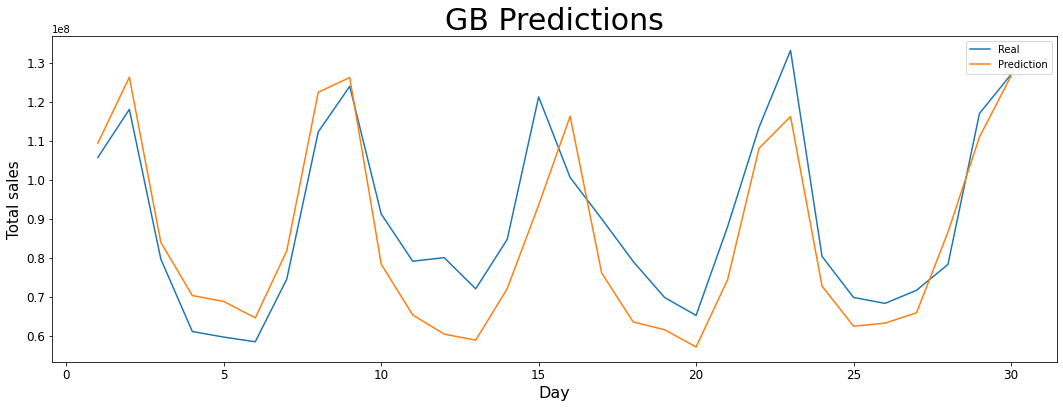

In [ ]:
plt.figure(figsize=(18, 6))
plt.xlabel('Day',fontsize=16)
plt.ylabel('Total sales',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('GB Predictions',fontsize=30)
plt.plot(range(1,31),y_test.values, label = "Real")
plt.plot(range(1,31),y_df_test[-30:].values, label = "Prediction")
plt.legend()
plt.show()

### RF-kNN - J.J

In [66]:
rf_knn = RF_KNN( n_trees = 35,  max_leaf_nodes = 2,  max_features=18,  n_neighbors = 10)
rf_knn.fit(dataScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M','month']], yscaled)

Training the kNN classifiers:


100%|██████████| 70/70 [00:01<00:00, 38.14it/s]


In [67]:
X_df_test=Df_hobbies_final.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M','month']].reset_index(drop=True)
y_df_test=Df_hobbies_final['total_sales'].reset_index(drop=True)

For Loop

In [68]:
for i in range(0,9):
  last180=y_df_test.iloc[-180:]
  newX=[]
  newX.append(last180.iloc[-30:].iloc[0]) #l 1
  newX.append(last180.iloc[-30:].iloc[2])  #l 24
  newX.append(last180.iloc[-30:].iloc[3])  #l 13
  newX.append(last180.iloc[-30:].iloc[6])   #l 7
  newX.append(last180.iloc[-30:].iloc[7])  #l 8
  newX.append(last180.iloc[-30:].iloc[8])  #l 9
  newX.append(last180.iloc[-30:].iloc[9])  #l 10
  newX.append(last180.iloc[-30:].iloc[15])  #l 16
  newX.append(last180.iloc[-30:].iloc[16])  #l 17
  newX.append(last180.iloc[-30:].iloc[18])  #l 19
  newX.append(last180.iloc[-30:].iloc[20])  #l 21
  newX.append(last180.iloc[-30:].iloc[21])  #l 22
  newX.append(last180.iloc[-30:].iloc[22])  #l 23
  newX.append(last180.iloc[-30:].iloc[23])  #l 24
  newX.append(last180.iloc[-30:].iloc[24])  #l 25
  newX.append(last180.iloc[-30:].iloc[29])  #l 30

  newX.append(last180.iloc[30:].max())   #Max 2M
  newX.append(last180.iloc[30:].min())   #Min 1M
  newX.append(last180.iloc[60:].mean())   #Mean 2M
  newX.append(last180.values.std())   #std 6M
  newX.append(last180.iloc[30:].kurt())   #Kurt 1M
  newX.append(last180.iloc[60:].kurt())   #Kurt 2M
  newX.append(5)   #month

  X_df_test.loc[len(X_df_test)] = newX
  #Final Prediction with test
  scaled= scaler.fit_transform(X_df_test)
  prediction = ( rf_knn.predict(scaled[-1:]).reshape(-1,1) )
  finalPrediction = scaler.inverse_transform(np.vstack([ scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1)) , prediction] ))
  y_df_test.loc[len(y_df_test)]=finalPrediction[-1][0] # The last predictions are the final Testing predictions

Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 988.08it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1409.04it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1466.36it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 734.04it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1495.94it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 798.20it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1398.14it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 1045.98it/s]


Predicting with the kNN classifiers:


100%|██████████| 35/35 [00:00<00:00, 760.22it/s]


In [69]:
print('MAE TEST:', mean_absolute_error(y_test.values,  y_df_test[-30:].values))

MAE TEST: 11822498.315118099


### SVR

In [45]:
regressor = SVR(kernel ='poly', C=0.5, degree=2)
regressor.fit(dataScaled.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M','month']], yscaled)

SVR(C=0.5, degree=2, kernel='poly')

In [46]:
X_df_test=Df_hobbies_final.loc[:,['l1', 'l3', 'l4', 'l7', 'l8', 'l9', 'l10', 'l16', 'l17', 'l19', 'l21','l22', 'l23', 'l24', 'l25', 'l30', 'max2M', 'min1M', 'mean2M', 'std6M',
       'kur1M', 'kur2M','month']].reset_index(drop=True)
y_df_test=Df_hobbies_final['total_sales'].reset_index(drop=True)

For Loop

In [47]:
for i in range(0,9):
  last180=y_df_test.iloc[-180:]
  newX=[]
  newX.append(last180.iloc[-30:].iloc[0]) #l 1
  newX.append(last180.iloc[-30:].iloc[2])  #l 24
  newX.append(last180.iloc[-30:].iloc[3])  #l 13
  newX.append(last180.iloc[-30:].iloc[6])   #l 7
  newX.append(last180.iloc[-30:].iloc[7])  #l 8
  newX.append(last180.iloc[-30:].iloc[8])  #l 9
  newX.append(last180.iloc[-30:].iloc[9])  #l 10
  newX.append(last180.iloc[-30:].iloc[15])  #l 16
  newX.append(last180.iloc[-30:].iloc[16])  #l 17
  newX.append(last180.iloc[-30:].iloc[18])  #l 19
  newX.append(last180.iloc[-30:].iloc[20])  #l 21
  newX.append(last180.iloc[-30:].iloc[21])  #l 22
  newX.append(last180.iloc[-30:].iloc[22])  #l 23
  newX.append(last180.iloc[-30:].iloc[23])  #l 24
  newX.append(last180.iloc[-30:].iloc[24])  #l 25
  newX.append(last180.iloc[-30:].iloc[29])  #l 30

  newX.append(last180.iloc[30:].max())   #Max 2M
  newX.append(last180.iloc[30:].min())   #Min 1M
  newX.append(last180.iloc[60:].mean())   #Mean 2M
  newX.append(last180.values.std())   #std 6M
  newX.append(last180.iloc[30:].kurt())   #Kurt 1M
  newX.append(last180.iloc[60:].kurt())   #Kurt 2M
  newX.append(5)   #month

  X_df_test.loc[len(X_df_test)] = newX
  #Final Prediction with test
  scaled= scaler.fit_transform(X_df_test)
  prediction = ( regressor.predict(scaled[-1:]).reshape(-1,1) )
  finalPrediction = scaler.inverse_transform(np.vstack([ scaler.fit_transform(Df_hobbies_final['total_sales'].values.reshape(-1, 1)) , prediction] ))
  y_df_test.loc[len(y_df_test)]=finalPrediction[-1][0] # The last predictions are the final Testing predictions


In [48]:
print('MAE TEST:', mean_absolute_error(y_test.values,  y_df_test[-30:].values))

MAE TEST: 11781817.342990994
